<a href="https://colab.research.google.com/github/DeviousLab/Amazon_Fake_Reviews_Model/blob/main/Amazon_Fake_Reviews_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake Amazon Review Model
---
## Case Study: Detect Fake Reviews on Amazon

**Objective:**
Figure out which features will allow a machine learning model to identify fake reviews/spam.

Build a basic fake review detection model that uses TfidfVectorizer and a range of machine learning algorithms to identify fake reviews from real reviews.

---
## Table of Contents 

### Section 1. Exploratory Data Analysis

* 1.1: Data Loading and Understanding 
* 1.2: Data Cleaning 
* 1.3: Data Visualization

### Section 2. Time-series Data Preparation for Forecasting

### Section 3. Building Time-series Models

### Section 4. Evaluating Time-series Models
--- 

## 0. Scenario, Problem & Dataset Description

The fake reviews dataset, containing 20k fake reviews and 20k real product reviews. OR = Original reviews (presumably human created and authentic); CG = Computer-generated fake reviews. 

The dataset includes computer generated fake reviews, which have the label CG, and original or human-generated reviews, which have the label OR. The fake reviews, tagged CG, were generated using the GPT-2 model, while the human-generated ones are human and should be real.

### The data contains the following attributes/features:

- category: the general category of the product e.g Electronics

- rating: rating given by the reviewer on the product. Determines the overall score of the review itself, given to the product supposedly purchased. Scale is from 1 - 5, 1 being very poor and 5 being excellent.

- label: unique identifier of the reviewr, CG being computer generated and OR being original reviews

- text: the actual review itself in text, explaining the product supposedly bought by the customer

You can find the dataset description [here](https://www.sciencedirect.com/science/article/pii/S0969698921003374?via%3Dihub).

# **1. Exploratory Data Analysis**

### Importing Libraries

*   [numpy](https://www.numpy.org/) - supports large, multidimensional arrays and has a lot of useful mathematical built-in functions to run on these arrays
*   [pandas](https://pandas.pydata.org/) - offers high-performance, easy-to-use data structures (e.g. can store data of multiple types in one data structure)
*   [matplotlib](https://matplotlib.org/) - 2D plotting library

In [3]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

### Data Loading 

You can download the dataset [here](https://osf.io/tyue9/).


In [4]:
!git clone https://github.com/DeviousLab/Amazon_Fake_Reviews_Model.git
%cd Amazon_Fake_Reviews_Model/dataset


# quickly visualize - print first 5 rows

Cloning into 'Amazon_Fake_Reviews_Model'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (9/9), done.
/content/Amazon_Fake_Reviews_Model/dataset/Amazon_Fake_Reviews_Model/dataset


### Data Inspection

In [ ]:
# inspect types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40433 entries, 0 to 40432
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  40433 non-null  object
 1   rating    40433 non-null  object
 2   label     40433 non-null  object
 3   text      40433 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


## Data Types

All of the attributes in the dataset happens to be of string/object. Since we are going to be reviewing the reviews itself, it is important to note that we have to consider the ones that are needed in regards to the FYP objectives.

To see whether we can go in the direction of behavioral or textual features, the columns should be inspected in depth.

There is are no integer values in the dataset, and hence there will be no focus on numerical features. 

There are 4 strings, so word cloud and other things can be seen in more depths to study its relationships with one another.

In [ ]:
# let's get a look at summary of statistics
data.describe()

,category,rating,label,text
count,40433,40433,40433,40433
unique,11,6,3,40413
top,Kindle_Store_5,5.0,CG,It does the job but it takes a lot of practice...
freq,4730,24559,20216,2


In [ ]:
# data shape
rows, cols = data.shape
print(f"The dataset is composed of {rows} rows and {cols} columns.")

The dataset is composed of 40433 rows and 4 columns.


In [ ]:
# checking for data balance in types of review
data['label'].value_counts()

CG       20216
OR       20216
label        1
Name: label, dtype: int64

In [ ]:
# checking for number of reviews in terms of rating
data['rating'].value_counts()

5.0       24559
4.0        7965
3.0        3786
1.0        2155
2.0        1967
rating        1
Name: rating, dtype: int64



---

### Data Cleaning

In [ ]:
data = pd.read_csv('/content/fake_reviews_dataset.csv')
data.head()  

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


Check for any null values in the dataset

In [ ]:
data.isnull().sum()

category    0
rating      0
label       0
text        0
dtype: int64

There are no NULL values for all the attributes needed for the analysis.

Next the dataset value needs to be checked for duplicate values.

In [ ]:
# check for any duplicates in full dataset
dup = data.duplicated().sum()
print("Number of duplicates in dataset: ", dup)

Number of duplicates in dataset:  12


In [ ]:
# remove duplicate reviews from dataset
data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40433 entries, 0 to 40432
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  40433 non-null  object
 1   rating    40433 non-null  object
 2   label     40433 non-null  object
 3   text      40433 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [ ]:
# remove newline characters from 'text' field
data['text_'] = data['text'].str.replace('\n', ' ')

Next, there will be a  new column called 'target' to hold the target variable, and assign the CG fake reviews with 1, and the real/OR reviews with 0

In [ ]:
# make a new column with whether review is OG or CG
data['target'] = np.where(data['label']=='CG', 1, 0)

data['target'].value_counts()

0    20217
1    20216
Name: target, dtype: int64

---

### Data Visualization

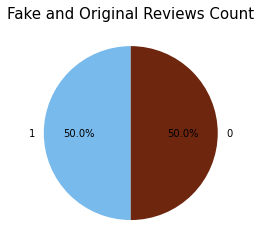

In [ ]:
# pie chart on fake reviews vs original reviews 
colors = ['#79BAEC','#6E260E']
plt.figure(figsize=(4,4))
label = data['target'].value_counts()
plt.pie(label.values,colors = colors, labels=label.index, autopct= '%1.1f%%', startangle=90)
plt.title('Fake and Original Reviews Count', fontsize=15)
plt.show()

Text(0.5, 1.0, 'Review Rating Grouped by type of Reviewer')

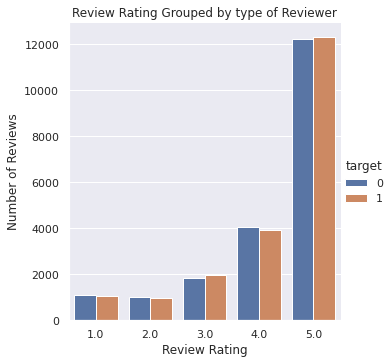

In [ ]:
# countplot of review rating grouped by type of reviewer
import seaborn as sns

sns.catplot(x ='rating',kind="count", hue="target",
            data=data)
plt.xlabel("Review Rating")
plt.ylabel("Number of Reviews")
plt.title("Review Rating Grouped by type of Reviewer")

Referring to the graph, it can be observed that the majority of reviews has a rating of 5 regardless of whether the reviewer is fake or not.

Looking at the 1 star rating, the fake reviewers happen to be more than the real reviews, which can indicate that the reviews were trying to demote the product.

Text(0.5, 1.0, 'Categories Grouped by type of Reviewer')

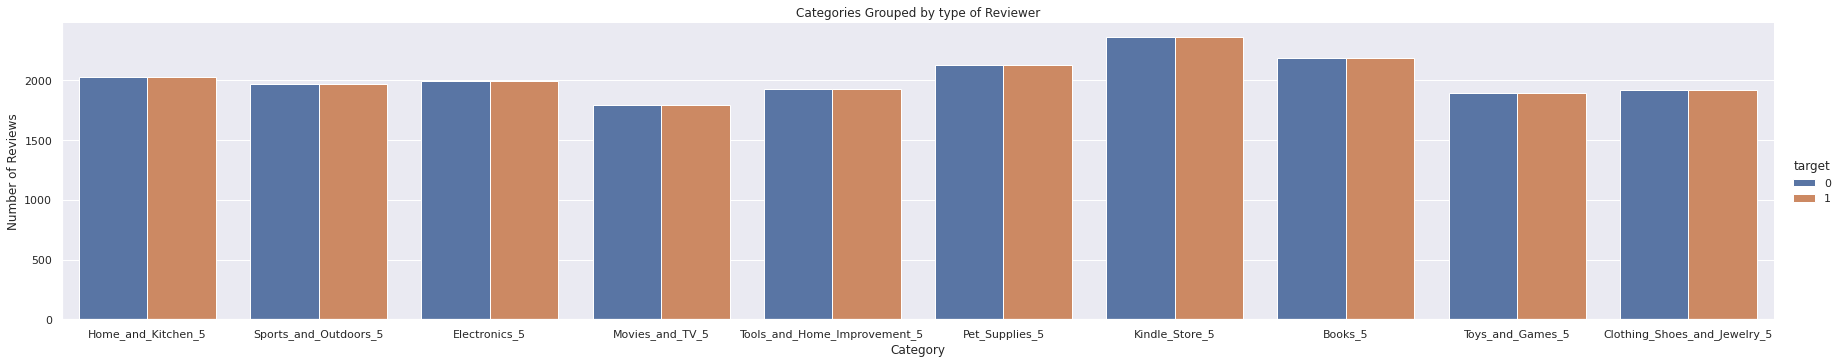

In [ ]:
# Using matplotlib
sns.catplot(x ='category',kind="count", hue = "target", data=data, height=5, aspect=5)
plt.xlabel("Category")
plt.ylabel("Number of Reviews")
plt.title("Categories Grouped by type of Reviewer")

It can be observed that in the dataset the number of reviews are nearly identical for both real and fake reviewers.

The Kindle store has the largest number of reviews out of any other category.

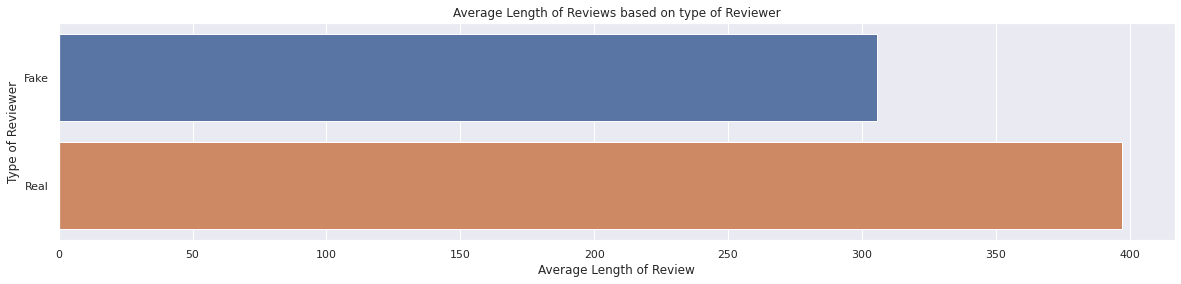

In [ ]:
cols = ["target", "text_"]
vprt = data[cols] 

# filter for fake reviewers
checkTrue = vprt["target"] == 1
filtered_true = vprt[checkTrue]

checkFalse = vprt["target"] == 0
filtered_false = vprt[checkFalse]

# checking for average review length
false_average_length = filtered_false["text_"].apply(len).mean()
true_average_length = filtered_true["text_"].apply(len).mean()

x = [true_average_length,false_average_length]
y = ["Fake", "Real"]
sns.barplot(x, y)
plt.xlabel("Average Length of Review")
plt.ylabel("Type of Reviewer")
plt.title("Average Length of Reviews based on type of Reviewer")
plt.show()

One of the key takeaways from this graph is the fact that the average length of reviews by real people exceed the ones which are flagged as fake.

It can seen here that the average length of the fake reviews happen to be more than 300 characters, whilst the real reivews happen to be around 400 characters.

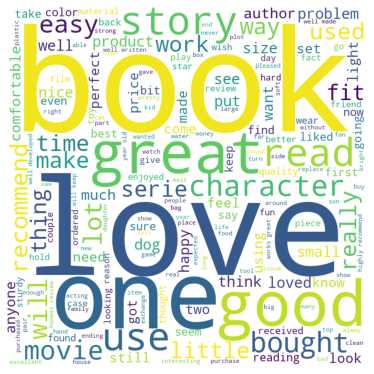

In [ ]:
# generate a word blob with most common words
from wordcloud import WordCloud

words = '' 
for i in data["text_"]: 
    tokens = i.split()   
    words += " ".join(tokens)+" "

    
word_cloud = WordCloud(width = 700, height = 700, 
                       background_color ='white', 
                       min_font_size = 10).generate(words) 
plt.figure(figsize = (5, 5)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Just for fun, a word blob has been made with the most common words in reviews.

---

# **2. Data Preparation**

The most appropriate type of model for this problem is a Bag of Words based model, so the review text needs some NLP preprocessing.

First, punctuation needs to be removed.

In [ ]:
# identify punctuation within a column and convert it to a text representation
def punctuation_to_features(df, column):
    df[column] = df[column].replace('!', ' exclamation ')
    df[column] = df[column].replace('?', ' question ')
    df[column] = df[column].replace('\'', ' quotation ')
    df[column] = df[column].replace('\"', ' quotation ')
    
    return df[column]

In [ ]:
data['text_'] = punctuation_to_features(data, 'text_')

Next the review text needs to be tokenised with NLTK.

In [ ]:
import nltk
nltk.download('punkt');

# tokenizes a dataframe column and returns a list of tokens
def tokenize(column):
    
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]    

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# tokenise review text and add it to a new column
data['tokenized'] = data.apply(lambda x: tokenize(x['text_']), axis=1)
data.head()

,category,rating,label,text,target,text_,tokenized
0,category,rating,label,text_,0,text_,[]
1,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1,"Love this! Well made, sturdy, and very comfor...","[Love, this, Well, made, sturdy, and, very, co..."
2,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",1,"love it, a great upgrade from the original. I...","[love, it, a, great, upgrade, from, the, origi..."
3,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,1,This pillow saved my back. I love the look and...,"[This, pillow, saved, my, back, I, love, the, ..."
4,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",1,"Missing information on how to use it, but it i...","[Missing, information, on, how, to, use, it, b..."


Next, the review text needs to be removed of stopwords.

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

# return a list of tokens with English stopwords removed
def remove_stopwords(tokenized_column):
    stops = set(stopwords.words("english"))
    return [word for word in tokenized_column if not word in stops]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# remove stopwords from tokenised column and add it to a new column
data['stopwords_removed'] = data.apply(lambda x: remove_stopwords(x['tokenized']), axis=1)
data.head()

,category,rating,label,text,target,text_,tokenized,stopwords_removed
0,category,rating,label,text_,0,text_,[],[]
1,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1,"Love this! Well made, sturdy, and very comfor...","[Love, this, Well, made, sturdy, and, very, co...","[Love, Well, made, sturdy, comfortable, I, lov..."
2,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",1,"love it, a great upgrade from the original. I...","[love, it, a, great, upgrade, from, the, origi...","[love, great, upgrade, original, I, mine, coup..."
3,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,1,This pillow saved my back. I love the look and...,"[This, pillow, saved, my, back, I, love, the, ...","[This, pillow, saved, back, I, love, look, fee..."
4,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",1,"Missing information on how to use it, but it i...","[Missing, information, on, how, to, use, it, b...","[Missing, information, use, great, product, pr..."


Finally, the review text needs to be stemmed with PorterStemmer to convert each word to its root, which can often really help model performance.

In [ ]:
from nltk.stem.porter import PorterStemmer

# return a list of tokens with Porter stemming applied
def apply_stemming(tokenized_column):
  
    stemmer = PorterStemmer() 
    return [stemmer.stem(word).lower() for word in tokenized_column]

In [ ]:
# stem words in stopwords_removed column and add it to a new column
data['porter_stemmed'] = data.apply(lambda x: apply_stemming(x['stopwords_removed']), axis=1)
data.head()

,category,rating,label,text,target,text_,tokenized,stopwords_removed,porter_stemmed
0,category,rating,label,text_,0,text_,[],[],[]
1,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1,"Love this! Well made, sturdy, and very comfor...","[Love, this, Well, made, sturdy, and, very, co...","[Love, Well, made, sturdy, comfortable, I, lov...","[love, well, made, sturdi, comfort, i, love, v..."
2,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",1,"love it, a great upgrade from the original. I...","[love, it, a, great, upgrade, from, the, origi...","[love, great, upgrade, original, I, mine, coup...","[love, great, upgrad, origin, i, mine, coupl, ..."
3,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,1,This pillow saved my back. I love the look and...,"[This, pillow, saved, my, back, I, love, the, ...","[This, pillow, saved, back, I, love, look, fee...","[thi, pillow, save, back, i, love, look, feel,..."
4,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",1,"Missing information on how to use it, but it i...","[Missing, information, on, how, to, use, it, b...","[Missing, information, use, great, product, pr...","[miss, inform, use, great, product, price, i]"


Now, the stemmed words need to be brought back together into a string.

In [ ]:
# join all the words back together
def rejoin_words(tokenized_column):
    return ( " ".join(tokenized_column))

In [ ]:
# stemmed words are put back into a string and add it to a new column
data['review_text'] = data.apply(lambda x: rejoin_words(x['porter_stemmed']), axis=1)
data[['review_text']].head()

,review_text
0,
1,love well made sturdi comfort i love veri pretti
2,love great upgrad origin i mine coupl year
3,thi pillow save back i love look feel pillow
4,miss inform use great product price i



## Create training and test data

Since this isn't a prediction problem, the test and training data can be allocated randomly in a 30/70 split.

In [ ]:
from sklearn.model_selection import train_test_split

# assigning variables
X = data['review_text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True)

# check shape
traindata = format(X_train.shape[0])
testdata = format(X_test.shape[0])

print('Number of rows:')
print('Train dataset:', traindata)
print('Test dataset:',testdata)


Number of rows:
Train dataset: 28303
Test dataset: 12130


# **3. Building the Model**

Let's review the whole dataframe again.

In [ ]:
data.head()

,category,rating,label,text,target,text_,tokenized,stopwords_removed,porter_stemmed,review_text
0,category,rating,label,text_,0,text_,[],[],[],
1,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1,"Love this! Well made, sturdy, and very comfor...","[Love, this, Well, made, sturdy, and, very, co...","[Love, Well, made, sturdy, comfortable, I, lov...","[love, well, made, sturdi, comfort, i, love, v...",love well made sturdi comfort i love veri pretti
2,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",1,"love it, a great upgrade from the original. I...","[love, it, a, great, upgrade, from, the, origi...","[love, great, upgrade, original, I, mine, coup...","[love, great, upgrad, origin, i, mine, coupl, ...",love great upgrad origin i mine coupl year
3,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,1,This pillow saved my back. I love the look and...,"[This, pillow, saved, my, back, I, love, the, ...","[This, pillow, saved, back, I, love, look, fee...","[thi, pillow, save, back, i, love, look, feel,...",thi pillow save back i love look feel pillow
4,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",1,"Missing information on how to use it, but it i...","[Missing, information, on, how, to, use, it, b...","[Missing, information, use, great, product, pr...","[miss, inform, use, great, product, price, i]",miss inform use great product price i


Let's check the word count using the CountVectorizer function, removing stopwords.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# check the word count in the review text
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer.fit(X_train)
print(count_vectorizer.vocabulary_)

train_c = count_vectorizer.fit_transform(X_train)
test_c = count_vectorizer.transform(X_test)


{'thi': 18868, 'projector': 14590, 'best': 1668, 'deal': 4548, 'veri': 20238, 'easi': 5610, 'setup': 16582, 'liter': 10801, 'got': 7733, 'minut': 11900, 'thing': 18882, 'unpack': 19920, 'box': 2126, 'plug': 14136, 'power': 14350, 'vga': 20273, 'cabl': 2555, 'comput': 3711, 'lot': 10961, 'stuff': 18087, 'menu': 11669, 'doubt': 5316, 'averag': 1143, 'joe': 9772, 'need': 12509, 'use': 20086, 'project': 14588, 'famili': 6407, 'room': 15813, 'wall': 20508, 'away': 1166, 'imag': 9014, 'bright': 2271, 'sharp': 16668, 'turn': 19540, 'haligen': 8098, 'light': 10701, 'veru': 20255, 'great': 7840, 'buy': 2529, 'puppi': 14761, 'love': 10987, 'bat': 1424, 'hear': 8357, 'sound': 17453, 'older': 13031, 'dog': 5230, 'pick': 13935, 'vibrat': 20280, 'walk': 20503, 'hardwood': 8220, 'floor': 6832, 'make': 11228, 'anim': 640, 'close': 3457, 'jodi': 9771, 'picoult': 13944, 'book': 2022, 'admit': 181, 'fan': 6411, 'seri': 16555, 'long': 10902, 'new': 12591, 'ipad': 9477, 'pro': 14536, 'coupl': 4024, 'week':

An alternative method would be to use TFIDF, which is a numerical statistic that shows the importance of a word in a text document.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# check the word originality in the review text
TFIDF_vectorizer  = TfidfVectorizer(stop_words='english')
TFIDF_vectorizer.fit(X_train)
print(TFIDF_vectorizer.vocabulary_)

train_tf = TFIDF_vectorizer.fit_transform(X_train)
test_tf = TFIDF_vectorizer.transform(X_test)

{'thi': 18868, 'projector': 14590, 'best': 1668, 'deal': 4548, 'veri': 20238, 'easi': 5610, 'setup': 16582, 'liter': 10801, 'got': 7733, 'minut': 11900, 'thing': 18882, 'unpack': 19920, 'box': 2126, 'plug': 14136, 'power': 14350, 'vga': 20273, 'cabl': 2555, 'comput': 3711, 'lot': 10961, 'stuff': 18087, 'menu': 11669, 'doubt': 5316, 'averag': 1143, 'joe': 9772, 'need': 12509, 'use': 20086, 'project': 14588, 'famili': 6407, 'room': 15813, 'wall': 20508, 'away': 1166, 'imag': 9014, 'bright': 2271, 'sharp': 16668, 'turn': 19540, 'haligen': 8098, 'light': 10701, 'veru': 20255, 'great': 7840, 'buy': 2529, 'puppi': 14761, 'love': 10987, 'bat': 1424, 'hear': 8357, 'sound': 17453, 'older': 13031, 'dog': 5230, 'pick': 13935, 'vibrat': 20280, 'walk': 20503, 'hardwood': 8220, 'floor': 6832, 'make': 11228, 'anim': 640, 'close': 3457, 'jodi': 9771, 'picoult': 13944, 'book': 2022, 'admit': 181, 'fan': 6411, 'seri': 16555, 'long': 10902, 'new': 12591, 'ipad': 9477, 'pro': 14536, 'coupl': 4024, 'week':

In [ ]:
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

classifiers = {}
classifiers.update({"XGBClassifier": XGBClassifier(eval_metric='logloss',
                                                   objective='binary:logistic',
                                                   )})
classifiers.update({"LinearSVC": LinearSVC()})
classifiers.update({"MultinomialNB": MultinomialNB()})
classifiers.update({"LGBMClassifier": LGBMClassifier()})
classifiers.update({"RandomForestClassifier": RandomForestClassifier()})
classifiers.update({"DecisionTreeClassifier": DecisionTreeClassifier()})
classifiers.update({"ExtraTreeClassifier": ExtraTreeClassifier()})
classifiers.update({"AdaBoostClassifier": AdaBoostClassifier()})
classifiers.update({"KNeighborsClassifier": KNeighborsClassifier()})
classifiers.update({"RidgeClassifier": RidgeClassifier()})
classifiers.update({"SGDClassifier": SGDClassifier()})
classifiers.update({"BaggingClassifier": BaggingClassifier()})
classifiers.update({"BernoulliNB": BernoulliNB()})


In [ ]:
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# pipeline with TfidfVectorizer
df_models_tf = pd.DataFrame(columns=['model', 'run_time', 'roc_auc', 'roc_auc_std'])

for key in classifiers:
    
    start_time = time.time()
    pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("clf", classifiers[key] )])
    cv = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'roc_auc': cv.mean(),
           'roc_auc_std': cv.std(),
    }
    
    df_models_tf = df_models_tf.append(row, ignore_index=True)
    
df_models_tf = df_models_tf.sort_values(by='roc_auc', ascending=False)

In [ ]:
# pipeline with CountVectorizer
df_models_c = pd.DataFrame(columns=['model', 'run_time', 'roc_auc', 'roc_auc_std'])

for key in classifiers:
    
    start_time = time.time()
    pipeline = Pipeline([("vect", CountVectorizer()), ("clf", classifiers[key] )])
    cv = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'roc_auc': cv.mean(),
           'roc_auc_std': cv.std(),
    }
    
    df_models_c = df_models_c.append(row, ignore_index=True)
    
df_models_c = df_models_c.sort_values(by='roc_auc', ascending=False)

NameError: ignored

In [ ]:
df_models_tf
df_models_c

,model,run_time,roc_auc,roc_auc_std
10,SGDClassifier,0.08,0.925622,0.008713
1,LinearSVC,0.09,0.922409,0.012600
9,RidgeClassifier,0.1,0.922279,0.013251
3,LGBMClassifier,1.46,0.918367,0.010663
4,RandomForestClassifier,4.6,0.911997,0.012754
2,MultinomialNB,0.07,0.901826,0.019809
0,XGBClassifier,0.97,0.863972,0.014855
11,BaggingClassifier,10.33,0.855397,0.011323
7,AdaBoostClassifier,0.55,0.843776,0.021098
12,BernoulliNB,0.07,0.828560,0.020344


# **4. Evaluating Time-series Models**

Recall, we want our input (X) and output (y) to look like:

```
[Input], [Output]
[d01, d02, d03, d04, d05, d06, d07], [d08, d09, d10, d11, d12, d13, d14]
[d02, d03, d04, d05, d06, d07, d08], [d09, d10, d11, d12, d13, d14, d15]
Etc ...
```

#### Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

# Now, we want to evaluate our model
predictions = np.array(predictions) # converting from list to np.array

# But we want to see how well our model is doing day by day 
scores = []
# calculate an RMSE score for each day
for i in range(y_test.shape[1]): # Loop over the days of each week (shape[1] refers to the days)
  # calculate mse for each day
  mse = mean_squared_error(y_test[:, i], predictions[:, i])
  rmse = np.sqrt(mse)
	# store
  scores.append(rmse)
 
# calculate overall RMSE for the entire week
weekly_score = np.array(scores).mean()

[AVG] ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']: 
 [403.635] [385.623, 390.63083, 395.7297, 400.64764, 403.57147, 416.79132, 432.45132]


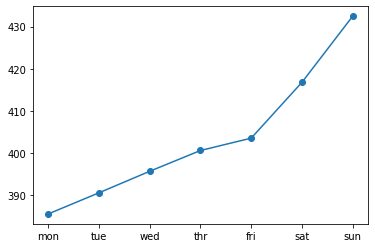

In [ ]:
# print and plot scores
days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
print('[AVG] %s: \n [%.3f] %s' % (days, weekly_score, scores))

plt.plot(days, scores, marker='o', label='lstm')
plt.show()

**References**

*   He, S., Hollenbeck, B. and Proserpio, D., 2022. The market for fake reviews. Marketing Science.
*   Ott, M., Choi, Y., Cardie, C. and Hancock, J.T., 2011. Finding deceptive opinion spam by any stretch of the imagination.
* Salminen, J., Kandpal, C., Kamel, A. M., Jung, S., and Jansen, B. J., 2022. Creating and detecting fake reviews of online products. Journal of Retailing and Consumer Services.



